In [19]:
# Full library imports
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Function imports
from tqdm import tqdm
from copy import deepcopy
from datetime import datetime

In [20]:
### Initializations

x_dim = 3
y_dim = 3

iterations = 250
num_sims = 100
np_seed = 6050

add_attack = True
add_attack_new_admm = add_attack
add_attack_orig_admm = add_attack
normalization = False

rho = 1
trust_threshold = 0.2
dyn_self_iso = False
attack_center = 1
attack_scale = 1.5

show_byz_plt = False
show_prob1 = False
show_prob2 = False

# Honest and Rogue Agents
num_agents = 10
num_byz = 3
gen_new_byz = False

# Function Defintions

trust_parameter_scale = 1e2
def trust_parameter(param):
    trust = trust_parameter_scale / ((np.linalg.norm(param)) + trust_parameter_scale)
    return trust

def attack_func(center, scale, iter):
    # return attack_center
    # return np.random.uniform(center - scale, center + scale)
    return np.random.normal(center, scale)
    # return center + iter*scale


# Edge List
edges = [   (0, 1), (0, 2), (0, 3),
            (0, 4), (0, 6), (1, 2),
            (1, 3), (1, 6), (2, 4),
            (2, 6), (2, 7), (2, 9),
            (3, 4), (3, 5), (3, 6),
            (4, 5), (4, 7), (5, 6),
            (5, 7), (5, 9), (6, 7),
            (6, 8), (7, 8), (7, 9),
            (8, 9), (0, 8), (1, 5),
            (4, 8)]
num_edges = len(edges)

arcs = deepcopy(edges)
num_arcs = 2*num_edges

for i in range(num_edges):
    this_edge = edges[i]
    new_edge = (this_edge[1], this_edge[0])
    edges.append(new_edge)

# Neighbor List - Agents are connected to each other
nbr_list = [None] * num_agents
for i in range(num_agents):
    nbr_list_i = []
    for j in range(num_arcs):
        this_arc = edges[j]
        if this_arc[0] == i:
            nbr_list_i.append(this_arc[1])
    nbr_list[i] = nbr_list_i

In [21]:
###     Storage Variables

avg_rmse_admm = np.zeros(num_agents)
avg_rmse_modif = np.zeros(num_agents)

rmse_hist_admm = [np.zeros(iterations) for i in range(num_agents)]
rmse_hist_modif = [np.zeros(iterations) for i in range(num_agents)]

avg_rmse_hist_admm = np.zeros(iterations)
avg_rmse_hist_modif = np.zeros(iterations)

mc_rmse_admm = [np.zeros((num_sims, num_agents)) for i in range(iterations)]
mc_rmse_modif = [np.zeros((num_sims, num_agents)) for i in range(iterations)]

sdv_rmse_hist_admm = [np.zeros(iterations) for i in range(num_agents)]
sdv_rmse_hist_modif = [np.zeros(iterations) for i in range(num_agents)]

byz_nodes_hist = [np.zeros(num_byz) for i in range(num_sims)]

In [22]:
###     Monte Carlo Outer Loop

if not gen_new_byz:
    ind_byz = deepcopy(np.random.choice(np.arange(0, num_agents), size=num_byz, replace=False))
ind_byz = np.array([1, 8, 9])
print(f"Byzantine Agents: {ind_byz}")

for sim_ind in tqdm(range(num_sims), desc="Simulations", leave=False):
    
    ### Assign Byzantine Nodes
    np.random.seed(np_seed + sim_ind)
    
    if gen_new_byz:
        ind_byz = deepcopy(np.random.choice(np.arange(0, num_agents), size=num_byz, replace=False))
        print(f"Simulation {sim_ind + 1} - Byzantine Agents: {ind_byz}")
    byz_nodes_hist[sim_ind] = ind_byz.flatten()
    
    ### Quadratic Objective Functions
    # f_i(x) = 0.5 || y_i - M_i*x ||^2
    y_arr = [None] * num_agents
    M_arr = [None] * num_agents

    for i in range(num_agents):
        y_i = np.random.normal(0, 1, (y_dim, 1))
        M_i = np.random.normal(0, 1, (y_dim, x_dim))
        
        y_arr[i] = y_i
        M_arr[i] = M_i



    ### Centralized: Finding optimal for all agents

    x_cp = cp.Variable((x_dim, 1))
    obj_func = 0
    for i in range(num_agents):
        obj_i = 0.5 * cp.power(cp.norm(y_arr[i] - M_arr[i] @ x_cp), 2)
        obj_func += obj_i
    prob_all = cp.Problem(cp.Minimize(obj_func))

    prob_all.solve()
    x_opt_all = np.array(x_cp.value).reshape((-1, 1))



    ### CENTRALIZED: Finding true optimal over honest agents

    x_cp = cp.Variable((x_dim, 1))
    obj_func = 0
    for i in range(num_agents):
        if i in ind_byz:
            continue
        obj_i = 0.5 * cp.power(cp.norm(y_arr[i] - M_arr[i] @ x_cp), 2)
        obj_func += obj_i
    prob_honest = cp.Problem(cp.Minimize(obj_func))

    prob_honest.solve()
    x_opt_honest = np.array(x_cp.value).reshape((-1, 1))



    ### REGULAR ADMM
    np.random.seed(np_seed + sim_ind)

    # Define x-variable
    x_cp_arr = []
    x_arr = []
    for i in range(num_agents):
        x_cp_arr.append(cp.Variable((x_dim, 1)))
        x_arr.append(np.zeros((x_dim, 1)))

    # Define local variables for edges
    lam_arr = [None] * num_agents
    tot_div_arr = [None] * num_agents

    for i in range(num_agents):
        lam_arr_i = {}
        tot_div_arr_i = {}
        
        for j in nbr_list[i]:
            lam_arr_i[j] = np.zeros((x_dim, 1))
            tot_div_arr_i[j] = np.zeros((x_dim, 1))
        
        lam_arr[i] = lam_arr_i
        tot_div_arr[i] = tot_div_arr_i
        
    # Storage Variables
    x_norm_diff_history = [np.zeros(iterations) for i in range(num_agents)]
    x_history_admm = [np.zeros((x_dim, iterations)) for i in range(num_agents)]

    # ADMM Iterations
    for iter in tqdm(range(iterations), desc="Normal ADMM", leave=False):
        # Store x
        for ind in range(num_agents):
            x_history_admm[ind][:, iter] = x_arr[ind].flatten()
        
        this_x_arr = x_arr
        
        # x-Update
        for ind in range(num_agents):
            obj_i = 0.5 * cp.power(cp.norm(y_arr[ind] - M_arr[ind] @ x_cp_arr[ind]), 2)
            
            for nbr_ind in nbr_list[ind]:
                nbr_x_arr = this_x_arr[nbr_ind]
                if add_attack_orig_admm and (nbr_ind in ind_byz):
                    nbr_x_arr += attack_func(attack_center, attack_scale, iter)
                obj_i += x_cp_arr[ind].T @ (lam_arr[ind][nbr_ind] - rho*(this_x_arr[ind] + nbr_x_arr))
                obj_i += rho * cp.power(cp.norm(x_cp_arr[ind]), 2)
            
            # Solve
            prob1 = cp.Problem(cp.Minimize(obj_i), [])
            try:
                prob1.solve(solver=cp.SCS, verbose=show_prob1)
            except cp.SolverError:
                print("Solver Error @ Prob 1")
                quit()
            
            # Byzantine Agent Conditional
            new_x = deepcopy(np.array(x_cp_arr[ind].value).reshape((-1, 1)))
            # if add_attack_orig_admm and (ind in ind_byz):
            #     new_x += attack_func(attack_center, attack_scale, iter)
                
                
            # Store
            x_arr[ind] = new_x
            x_norm_diff = np.linalg.norm(new_x - x_opt_all)
            # if add_attack_orig_admm:
            #     x_norm_diff = np.linalg.norm(new_x - x_opt_honest)
            x_norm_diff_history[ind][iter] = x_norm_diff


        # lam-Update
        for ind in range(num_agents):
            for nbr_ind in nbr_list[ind]:
                constr_dev = (x_arr[ind] - x_arr[nbr_ind])
                lam_arr[ind][nbr_ind] += rho*(constr_dev)
    
    
    ## Compute average RMSE for reg agents
    
    for ind in range(num_agents):
        
        tot_rmse = 0
        for iter in range(iterations):
            this_rmse = x_norm_diff_history[ind][iter]
            rmse_hist_admm[ind][iter] += (this_rmse / num_sims)
            mc_rmse_admm[iter][sim_ind, ind] = this_rmse
            if ind not in ind_byz:
                tot_rmse += this_rmse
                avg_rmse_hist_admm[iter] += (this_rmse) / ((num_agents - num_byz) * num_sims) # average rmse over all agents at this iter 
        
        avg_rmse_admm[ind] = (tot_rmse) / (iterations * num_sims) # average rmse for agent ind over whole MC run
        


    ### PROPOSED MODIFIED OPTIMIZATION
    np.random.seed(np_seed + sim_ind)

    # Define x-variable
    x_cp_arr = []
    x_arr = []
    for i in range(num_agents):
        x_cp_arr.append(cp.Variable((x_dim, 1)))
        x_arr.append(np.zeros((x_dim, 1)))

    # Define local variables for edges
    lam_arr = [None] * num_agents
    tot_div_arr = [None] * num_agents

    for i in range(num_agents):
        lam_arr_i = {}
        tot_div_arr_i = {}
        
        tot_div_arr_i[i] = np.zeros((x_dim, 1)) # Total Divergence for Self
        for j in nbr_list[i]:
            lam_arr_i[j] = np.zeros((x_dim, 1))
            tot_div_arr_i[j] = np.zeros((x_dim, 1)) # Total Divergence for Neighbor
        
        lam_arr[i] = lam_arr_i
        tot_div_arr[i] = tot_div_arr_i
        
    # Storage Variables
    x_norm_diff_history = [np.zeros(iterations) for i in range(num_agents)]
    x_history_modif = [np.zeros((x_dim, iterations)) for i in range(num_agents)]
    
    # Define Trust Variable
    trust = np.ones((num_agents, num_agents))
    for i in range(num_agents):
        for j in range(num_agents):
            if i == j:
                trust[i][j] = 0
                
    if normalization:
        trust = trust / (num_agents - 1)

    # ADMM Iterations
    for iter in tqdm(range(iterations), desc="Proposed Algo", leave=False):
        # Store x
        for ind in range(num_agents):
            x_history_modif[ind][:, iter] = x_arr[ind].flatten()
            
        this_x_arr = x_arr
        
        # x-Update
        for ind in range(num_agents):
            obj_i = 0.5 * cp.power(cp.norm(y_arr[ind] - M_arr[ind] @ x_cp_arr[ind]), 2)
            
            for nbr_ind in nbr_list[ind]:
                aij = 1
                if (ind not in ind_byz):
                    aij = trust[ind][nbr_ind] #trust_parameter(tot_div_arr[ind][nbr_ind])
                nbr_x_arr = this_x_arr[nbr_ind]
                if add_attack_new_admm and (nbr_ind in ind_byz):
                    nbr_x_arr += attack_func(attack_center, attack_scale, iter)
                obj_i += x_cp_arr[ind].T @ (lam_arr[ind][nbr_ind] - aij*(this_x_arr[ind] + nbr_x_arr))
                obj_i += aij * cp.power(cp.norm(x_cp_arr[ind]), 2)
            
            # Solve
            prob1 = cp.Problem(cp.Minimize(obj_i), [])
            try:
                prob1.solve(solver=cp.SCS, verbose=show_prob1)
            except cp.SolverError:
                print("Solver Error @ Prob 1")
                quit()
            
            # Byzantine Agent Conditional
            new_x = deepcopy(np.array(x_cp_arr[ind].value).reshape((-1, 1)))
            # if add_attack_new_admm and (ind in ind_byz):
            #     new_x += attack_func(attack_center, attack_scale, iter)
                
                
            # Store
            x_arr[ind] = new_x
            x_norm_diff = np.linalg.norm(new_x - x_opt_all)
            # if add_attack_new_admm:
            #     x_norm_diff = np.linalg.norm(new_x - x_opt_honest)
            x_norm_diff_history[ind][iter] = x_norm_diff


        # lam-Update
        for ind in range(num_agents):
        
            tot_trust_i = 0
            
            for nbr_ind in nbr_list[ind]:
                aij = 1
                if (ind not in ind_byz):
                    aij = trust[ind][nbr_ind] #trust_parameter(tot_div_arr[ind][nbr_ind]) # lam_arr[ind][nbr_ind]
                # trust_history[ind][nbr_ind, iter] = aij
                    
                constr_dev = (x_arr[ind] - x_arr[nbr_ind])
                lam_arr[ind][nbr_ind] += (aij*constr_dev)
                tot_div_arr[ind][nbr_ind] += np.power(np.abs(1*constr_dev), 2)
                tot_div_arr[ind][ind] += np.power(np.abs(1*constr_dev), 2)
                
                new_trust = trust_parameter(tot_div_arr[ind][nbr_ind])
                # new_trust = trust_parameter(lam_arr[ind][nbr_ind])
                
                if new_trust < trust_threshold:
                    new_trust = 0
                if not dyn_self_iso:
                    trust[ind][nbr_ind] = new_trust
                tot_trust_i += new_trust

            for nbr_ind in nbr_list[ind]:
                new_trust = trust_parameter(tot_div_arr[ind][ind])
                if new_trust < trust_threshold:
                    new_trust = 0
                if dyn_self_iso:
                    trust[ind][nbr_ind] = new_trust
            
            # Normalize Trust
            if normalization:
                trust[ind][:] = trust[ind][:] / tot_trust_i
    
    
    ## Compute average RMSE for reg agents
    for ind in range(num_agents):
        
        tot_rmse = 0
        for iter in range(iterations):
            this_rmse = x_norm_diff_history[ind][iter]
            rmse_hist_modif[ind][iter] += (this_rmse / num_sims)
            mc_rmse_modif[iter][sim_ind, ind] = this_rmse
            if ind not in ind_byz:
                tot_rmse += this_rmse
                avg_rmse_hist_modif[iter] += (this_rmse) / ((num_agents - num_byz) * num_sims)
        
        avg_rmse_modif[ind] = (tot_rmse) / (iterations * num_sims)

Byzantine Agents: [1 8 9]


In [23]:
###     Post Processing

# Compute Standard Deviation of RMSE
for iter in range(iterations):
    for ind in range(num_agents):
        sdv_rmse_hist_admm[ind][iter] = np.std(mc_rmse_admm[iter][:, ind])
        sdv_rmse_hist_modif[ind][iter] = np.std(mc_rmse_modif[iter][:, ind])
        
# Compute Average RMSE for each Simulation
avg_rmse_sims_admm = np.zeros(num_sims)
avg_rmse_sims_modif = np.zeros(num_sims)
for sim_ind in range(num_sims):
    this_rmse_admm = 0
    this_rmse_modif = 0
    for iter in range(iterations):
        this_rmse_admm += np.mean(mc_rmse_admm[iter][sim_ind, :].flatten()) / iterations
        this_rmse_modif += np.mean(mc_rmse_modif[iter][sim_ind, :].flatten()) / iterations
    avg_rmse_sims_admm[sim_ind] = this_rmse_admm
    avg_rmse_sims_modif[sim_ind] = this_rmse_modif
    
    print(f"Simulation {sim_ind + 1} - Attacked Node(s): {byz_nodes_hist[sim_ind]}")
    print(f"\tAvg RMSE ADMM: {this_rmse_admm}, Avg RMSE Modified: {this_rmse_modif}")

Simulation 1 - Attacked Node(s): [1 8 9]
	Avg RMSE ADMM: 4.08135753483315, Avg RMSE Modified: 4.254485174264799
Simulation 2 - Attacked Node(s): [1 8 9]
	Avg RMSE ADMM: 6.197839028604121, Avg RMSE Modified: 5.623021521574478
Simulation 3 - Attacked Node(s): [1 8 9]
	Avg RMSE ADMM: 9.487823342257673, Avg RMSE Modified: 9.126269880951686
Simulation 4 - Attacked Node(s): [1 8 9]
	Avg RMSE ADMM: 5.872667207267058, Avg RMSE Modified: 5.843509693568429
Simulation 5 - Attacked Node(s): [1 8 9]
	Avg RMSE ADMM: 8.340875266275306, Avg RMSE Modified: 7.991965134796064
Simulation 6 - Attacked Node(s): [1 8 9]
	Avg RMSE ADMM: 7.849538503248867, Avg RMSE Modified: 5.409256652419123
Simulation 7 - Attacked Node(s): [1 8 9]
	Avg RMSE ADMM: 8.105919251796902, Avg RMSE Modified: 6.928602116175742
Simulation 8 - Attacked Node(s): [1 8 9]
	Avg RMSE ADMM: 5.073753766844529, Avg RMSE Modified: 4.352642306521071
Simulation 9 - Attacked Node(s): [1 8 9]
	Avg RMSE ADMM: 6.100331363036026, Avg RMSE Modified: 4.

Text(0.5, 1.0, 'ADMM - with Byzantine Nodes')

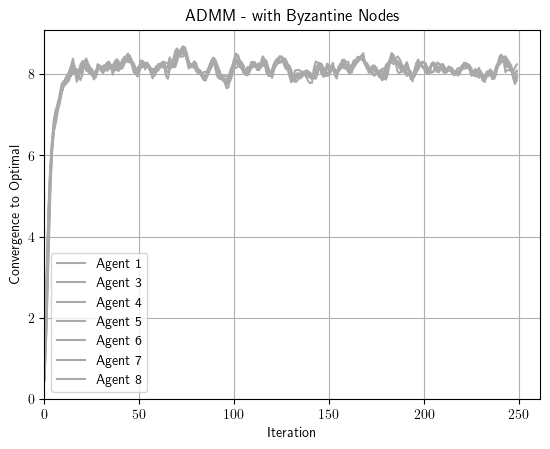

In [24]:
plt.rcParams.update({'text.usetex': True})

###     PLOT: ADMM Results
admm_conv_plt = plt.figure()
admm_conv_ax = admm_conv_plt.add_subplot()
for i in range(num_agents):
    
    if (i in ind_byz) and show_byz_plt:
        color = 'orangered'
        admm_conv_ax.plot(np.arange(iterations), rmse_hist_admm[i], label=f"Agent {i+1}", color=color)
        
    elif (i not in ind_byz): 
        color = 'darkgray'
        admm_conv_ax.plot(np.arange(iterations), rmse_hist_admm[i], label=f"Agent {i+1}", color=color)
    
conv_title2 = "without Byzantine Nodes"
if add_attack_new_admm:
    conv_title2 = "with Byzantine Nodes"

admm_conv_ax.legend()
admm_conv_ax.set_xlabel("Iteration")
admm_conv_ax.set_ylabel("Convergence to Optimal")
admm_conv_ax.set_ylim(bottom=0)
admm_conv_ax.set_xlim(left=0)
admm_conv_ax.grid(True)
admm_conv_ax.set_title(f"ADMM - {conv_title2}")

Text(0.5, 1.0, 'MODIFIED - with Byzantine Nodes')

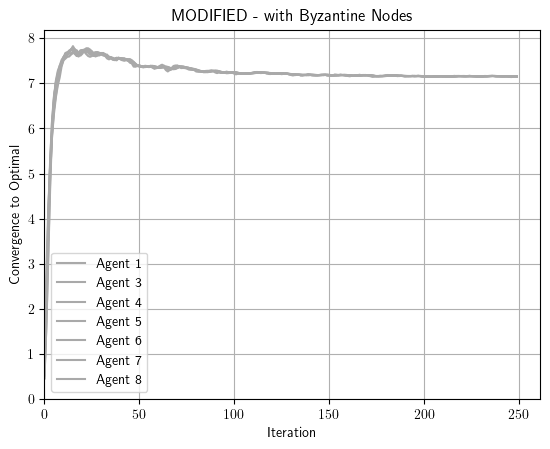

In [25]:
###     PLOT: Modified Opti Results
modif_conv_plt = plt.figure()
modif_conv_ax = modif_conv_plt.add_subplot()
for i in range(num_agents):
    
    if (i in ind_byz) and show_byz_plt:
        color = 'orangered'
        modif_conv_ax.plot(np.arange(iterations), rmse_hist_modif[i], label=f"Agent {i+1}", color=color)
        
    elif (i not in ind_byz): 
        color = 'darkgray'
        modif_conv_ax.plot(np.arange(iterations), rmse_hist_modif[i], label=f"Agent {i+1}", color=color)

modif_conv_ax.legend()
modif_conv_ax.set_xlabel("Iteration")
modif_conv_ax.set_ylabel("Convergence to Optimal")
modif_conv_ax.set_ylim(bottom=0)
modif_conv_ax.set_xlim(left=0)
modif_conv_ax.grid(True)
modif_conv_ax.set_title(f"MODIFIED - {conv_title2}")

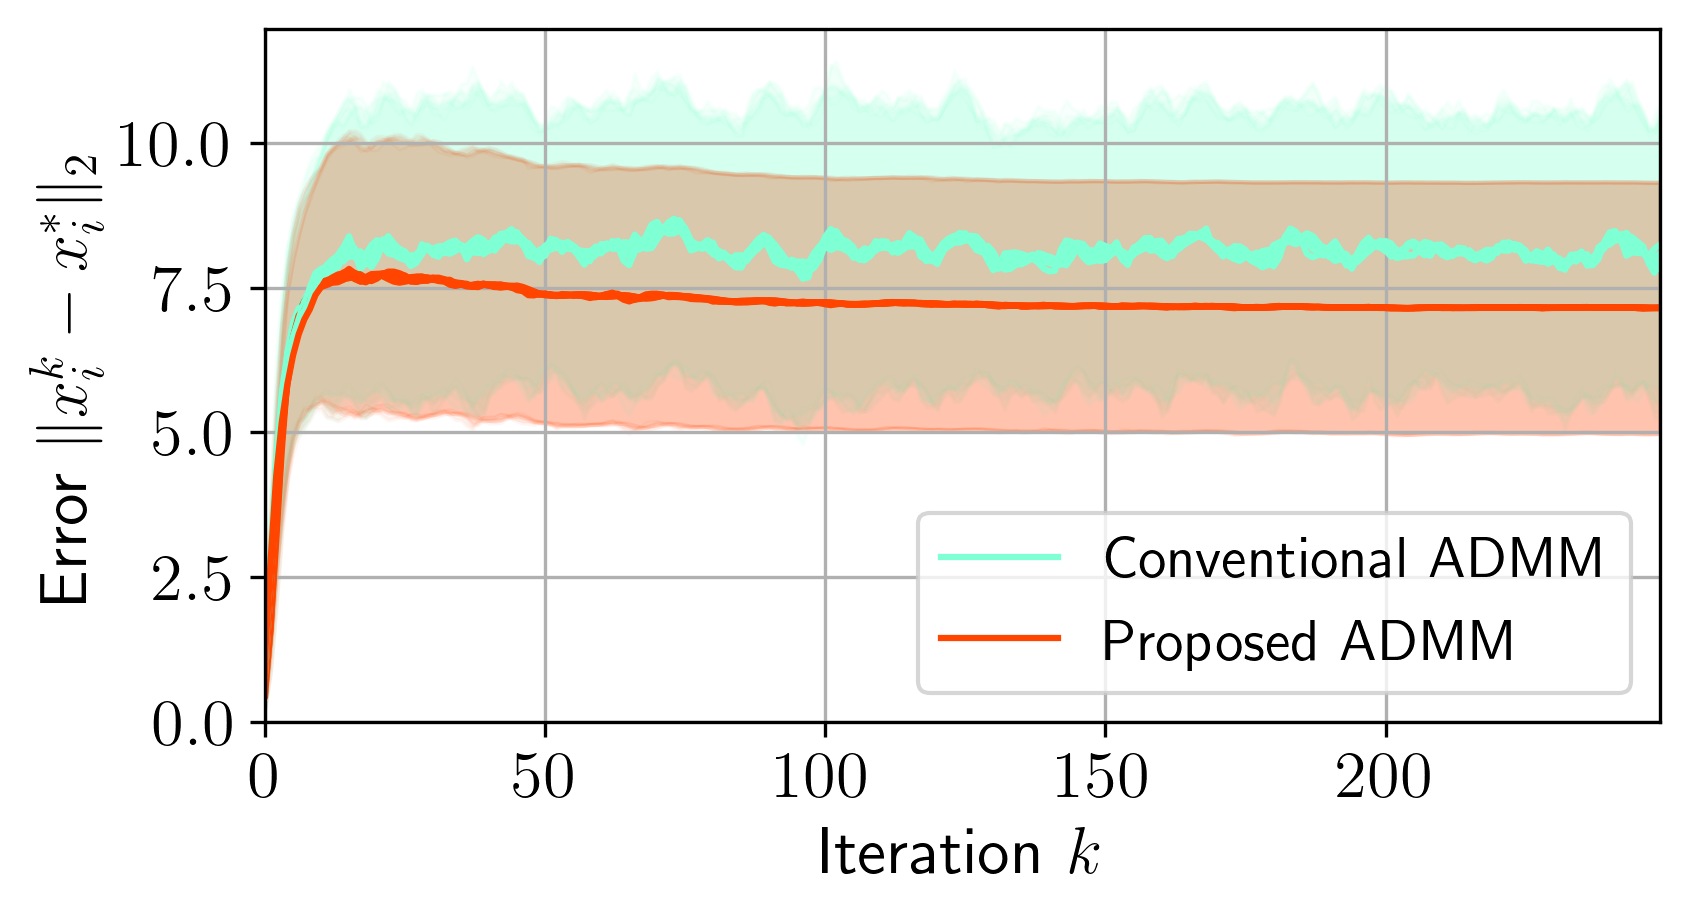

In [26]:
###     PLOT: ADMM vs. Modified

comp_conv_plt = plt.figure(dpi=300, figsize=(6, 3))
comp_conv_ax = comp_conv_plt.add_subplot()
for i in range(num_agents):
    # Nominal Line Format
    line_style = '-'
    admm_col = 'aquamarine'
    modif_col = 'orangered'
    
    # Byz Line Format
    if (i in ind_byz):
        if show_byz_plt:
            admm_col = 'yellowgreen'
            modif_col = 'goldenrod'
            # line_style = '--'
        else:
            continue
    comp_conv_ax.plot(np.arange(iterations), rmse_hist_admm[i], label="ADMM", color=admm_col, linestyle=line_style)
    comp_conv_ax.plot(np.arange(iterations), rmse_hist_modif[i], label="Modified ADMM", color=modif_col, linestyle=line_style)

    comp_conv_ax.fill_between(np.arange(iterations), rmse_hist_admm[i] - sdv_rmse_hist_admm[i], 
                              rmse_hist_admm[i] + sdv_rmse_hist_admm[i], color=admm_col, alpha=0.05)
    comp_conv_ax.fill_between(np.arange(iterations), rmse_hist_modif[i] - sdv_rmse_hist_modif[i], 
                              rmse_hist_modif[i] + sdv_rmse_hist_modif[i], color=modif_col, alpha=0.05)

comp_conv_ax.legend(["Conventional ADMM", "Proposed ADMM"], loc="lower right", fontsize=14)
comp_conv_ax.set_xlabel(r'Iteration $k$', fontsize=16)
comp_conv_ax.set_ylabel(r'Error $ \| x^k_i - x_i^* \|_2 $', fontsize=16)
comp_conv_ax.tick_params(axis='both', which='major', labelsize=16)
comp_conv_ax.set_ylim(bottom=0)
comp_conv_ax.set_xlim(left=0, right=iterations-1)
comp_conv_ax.grid(True)
# comp_conv_ax.set_title(f"Comparison of Methods, {conv_title2}", fontsize=18)

# Save Figure
fname_att = "-no_attack-"
if add_attack_new_admm:
    fname_att = "-with_attack-"
save_plt = True
dt_string = datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
fname_err = "figs/comp" + fname_att + dt_string + ".pdf"
if save_plt:
    plt.savefig(fname_err, dpi=300, bbox_inches='tight')

In [27]:
plt.show()

print("Completed at: ", dt_string)

Completed at:  2025_07_23-18_36_14
